In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

class kmeans:
    def __init__(self , k):
        self.k = k
        self.centroids = None
        self.labels = None
        self.n_samples = None
        self.n_features = None

    def fit(self, data):
        self.n_samples, self.n_features = data.shape
        self.centroids = data[np.random.choice(self.n_samples, self.k, replace=False)]
        self.labels = np.zeros(self.n_samples)

        while True:

            for i in range(self.n_samples):
                distances = np.linalg.norm(data[i] - self.centroids, axis=1)
                self.labels[i] = np.argmin(distances)

            old_centroids = self.centroids
            for i in range(self.k):
                self.centroids[i] = np.mean(data[self.labels == i], axis=0)

            if np.all(old_centroids == self.centroids):
                break

    def predict(self, data):
        n_samples, _ = data.shape
        labels = np.zeros(n_samples)
        for i in range(n_samples):
            distances = np.linalg.norm(data[i] - self.centroids, axis=1)
            labels[i] = np.argmin(distances)
        return labels
    


In [5]:

def k_means_clustering(k, data):
    """
    Performs k-means clustering on color pixels.
    """
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids



def my_own_kmean_clustering(k , data):

    
    """

    Performs k-means clustering on color pixels using my own implementation.
    
    """
    km = kmeans(k)
    km.fit(data)
    labels = km.labels
    centroids = km.centroids
    return labels , centroids
    

def get_seed_pixels(image, mask):
    """
    Extracts seed pixels from an image based on a given mask.

    """
    height, width, n_channels = image.shape
    mask = mask.astype(bool)
    seed_pixels = image[mask].reshape(-1, n_channels)
    return seed_pixels


def compute_likelihood(pixel, cluster_centers, w):
    """
    Computes the likelihood of a given pixel to belong to each cluster.

    """
    n_clusters = cluster_centers.shape[0]
    distances = np.linalg.norm(pixel - cluster_centers, axis=1)
    likelihoods = np.exp(-distances) * w
    return likelihoods


def lazy_snapping(image, foreground_mask, background_mask, k=64 , use_own_kmeans = False):
    """
    Performs Lazy Snapping for image segmentation.
    """
    height, width, _ = image.shape


    foreground_pixels = get_seed_pixels(image, foreground_mask)
    background_pixels = get_seed_pixels(image, background_mask)


    if use_own_kmeans:
        foreground_labels, foreground_centroids = my_own_kmean_clustering(k, foreground_pixels)
        background_labels, background_centroids = my_own_kmean_clustering(k, background_pixels)
    else:
        foreground_labels, foreground_centroids = k_means_clustering(k, foreground_pixels)
        background_labels, background_centroids = k_means_clustering(k, background_pixels)


    foreground_w = np.bincount(foreground_labels.astype('int'), minlength=k) / len(foreground_labels.astype('int'))
    background_w = np.bincount(background_labels.astype('int'), minlength=k) / len(background_labels.astype('int'))

    segmentation_mask = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]
            foreground_likelihoods = compute_likelihood(pixel, foreground_centroids, foreground_w)
            background_likelihoods = compute_likelihood(pixel, background_centroids, background_w)


            foreground_likelihood = np.sum(foreground_likelihoods)
            background_likelihood = np.sum(background_likelihoods)

            if foreground_likelihood > background_likelihood:
                segmentation_mask[i, j] = 1

    return segmentation_mask


In [6]:

def separate_red_blue_strokes(image_path):

    """
    separates red and blue strokes from a given image.

    """

    image = cv2.imread(image_path)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])


    lower_blue = np.array([110, 50, 50])
    upper_blue = np.array([130, 255, 255])


    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)


    red_strokes = cv2.bitwise_and(image, image, mask=mask_red)
    blue_strokes = cv2.bitwise_and(image, image, mask=mask_blue)

    return red_strokes, blue_strokes

    



In [16]:
def show_image(image1 , image2 , stroke):
    """
    show two images side by side
    """
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(image1)
    axes[0].set_title("Original Image")

    axes[1].imshow(image2)
    axes[1].set_title("Segmented Image")

    axes[2].imshow(stroke)
    axes[2].set_title("Stroke")

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')


    plt.subplots_adjust(wspace=0.2)
    plt.show()

In [8]:

image_path = "Mona-lisa.PNG" 
image = cv2.imread(image_path)
print(image.shape)


image_display = image.copy()


foreground_points = []
background_points = []


drawing_foreground = True


stroke_color = (0, 0, 255) # Red


def draw_strokes(event, x, y, flags, param):
    global image_display, foreground_points, background_points, drawing_foreground, stroke_color
    if event == cv2.EVENT_LBUTTONDOWN:
        if drawing_foreground:
            foreground_points.append((x, y))
        else:
            background_points.append((x, y))
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        if drawing_foreground:
            foreground_points.append((x, y))
        else:
            background_points.append((x, y))
    elif event == cv2.EVENT_RBUTTONDOWN:
        drawing_foreground = not drawing_foreground
        if drawing_foreground:
            stroke_color = (0, 0, 255)  # Red
        else:
            stroke_color = (255, 0, 0)  # Blue


cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_strokes)

while True:

    image_display = image.copy()
    for point in foreground_points:
        cv2.circle(image_display, point, 5, (0, 0, 255), -1)  # Draw red circle for foreground
    for point in background_points:
        cv2.circle(image_display, point, 5, (255, 0, 0), -1)  # Draw blue circle for background
    cv2.imshow("Image", image_display)
    key = cv2.waitKey(1)


    if key == ord('c'):
        foreground_points = []
        background_points = []


    if key == ord('e'):

        mask = np.zeros_like(image)


        for point in foreground_points:
            cv2.circle(mask, point, 5, (0, 0, 255), -1)  # Draw white circle for foreground
        for point in background_points:
            cv2.circle(mask, point, 5, (255, 0, 0), -1)  # Draw white circle for background

        cv2.imwrite("mask.png", mask)

        
        


    if key == ord('q'):
        break

cv2.destroyAllWindows()



(414, 431, 3)


In [9]:
testing_dictionary = {
'Mona-lisa.PNG' :[ 'Mona-lisa stroke 1.png', 'Mona-lisa stroke 2.png'],
'lady.PNG' : ['lady stroke 1.png', 'lady stroke 2.png'],

'van Gogh.PNG' : ['van Gogh stroke.png'],
}

sklearn impl--- 5.772054195404053 seconds ---


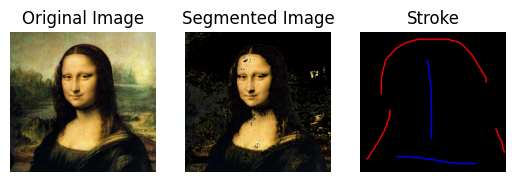

C:\Users\ubair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ubair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


own impl--- 6.96025824546814 seconds ---


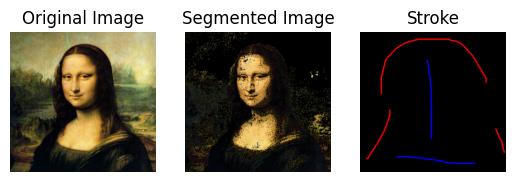

sklearn impl--- 6.856084585189819 seconds ---


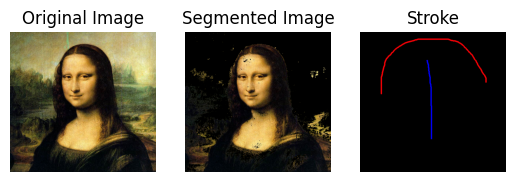

own impl--- 7.775995969772339 seconds ---


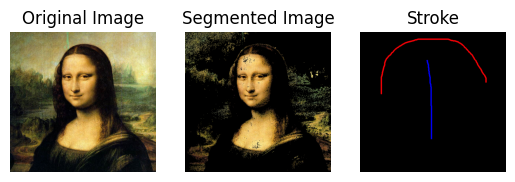

sklearn impl--- 5.984912395477295 seconds ---


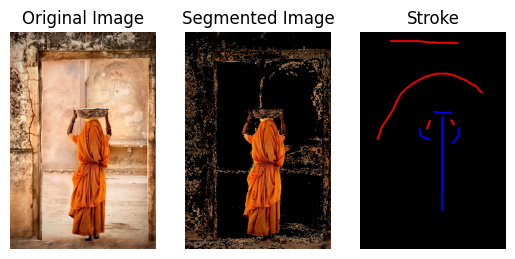

own impl--- 8.375003814697266 seconds ---


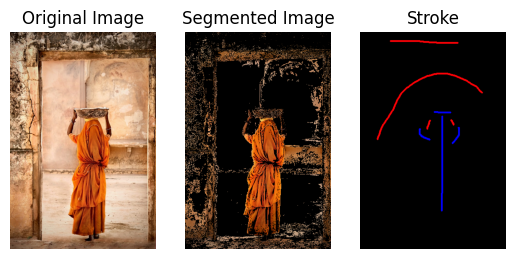

sklearn impl--- 6.898809909820557 seconds ---


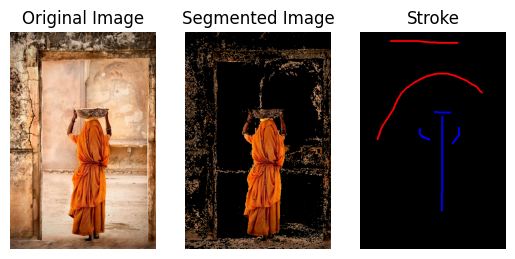

own impl--- 7.213204860687256 seconds ---


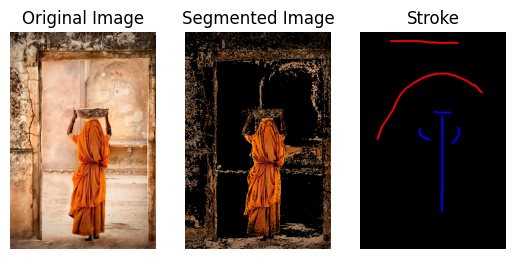

sklearn impl--- 8.434895038604736 seconds ---


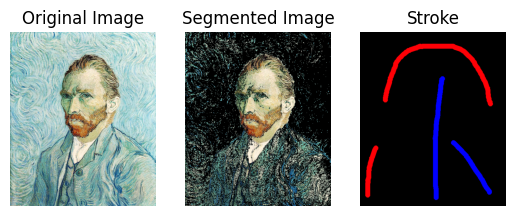

own impl--- 9.299244403839111 seconds ---


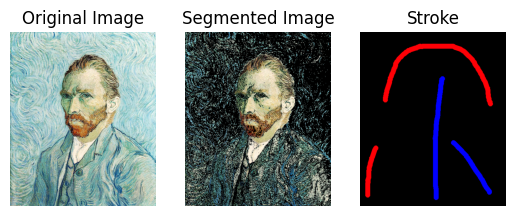

In [17]:

for i , j in testing_dictionary.items():
    image_path = i
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for k in j:
        red_strokes, blue_strokes = separate_red_blue_strokes(k)
        foreground_seed = cv2.cvtColor(red_strokes, cv2.COLOR_BGR2GRAY)
        background_seed = cv2.cvtColor(blue_strokes, cv2.COLOR_BGR2GRAY)
        _, foreground_mask = cv2.threshold(foreground_seed, 1, 255, cv2.THRESH_BINARY)
        _, background_mask = cv2.threshold(background_seed, 1, 255, cv2.THRESH_BINARY)


        start_time = time.time()

        segmentation_mask = lazy_snapping(image, foreground_mask, background_mask , use_own_kmeans = False)

        print("sklearn impl--- %s seconds ---" % (time.time() - start_time))

        orginal_image = image.copy()
        image[segmentation_mask == 0] = (0, 0, 0)
        
        show_image(orginal_image, image , cv2.imread(k))

        image = orginal_image

        start_time = time.time()

        segmentation_mask = lazy_snapping(image, foreground_mask, background_mask , use_own_kmeans = True)

        print("own impl--- %s seconds ---" % (time.time() - start_time))

        orginal_image = image.copy()
        image[segmentation_mask == 0] = (0, 0, 0)
        
        show_image(orginal_image, image , cv2.imread(k))

        image = orginal_image

